In [ ]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
print(f'pandas == {pd.__version__}')
print(f'statsmodels == {statsmodels.__version__}')

pandas == 1.3.5
statsmodels == 0.13.2


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
df = pd.read_csv('bcdata.sgs.24363.csv', delimiter=';', decimal=',', parse_dates=['data'], index_col='data', dayfirst=True)

In [ ]:
df.head()

,valor
data,
2003-01-01,96.15
2003-02-01,98.67
2003-03-01,103.41
2003-04-01,102.19
2003-05-01,100.30


In [ ]:
df.describe()

,valor
count,230.000000
mean,130.858000
std,13.710214
min,96.150000
25%,122.027500
50%,135.355000
75%,140.287500
max,152.130000


In [ ]:
df.shape

(230, 1)

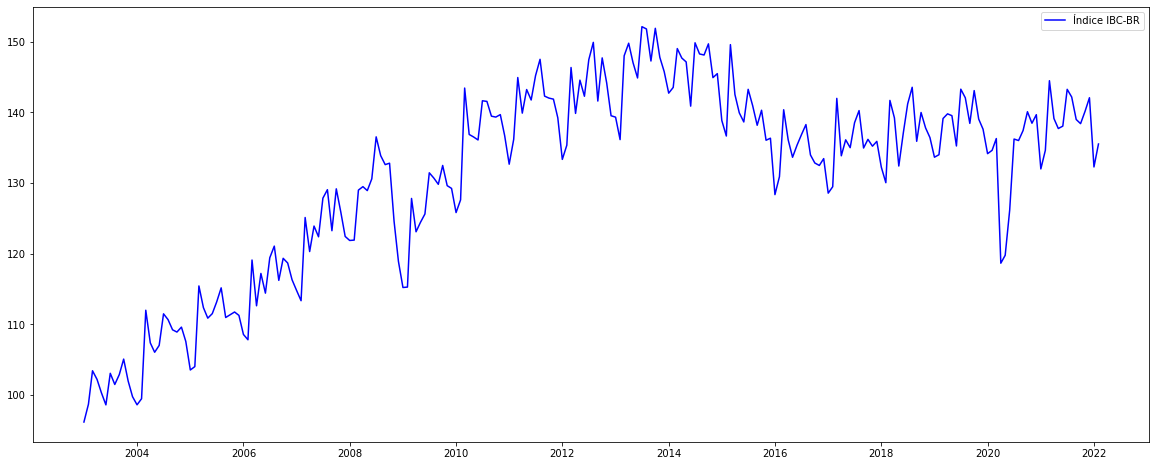

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df['valor'], 'b')
plt.legend(['Índice IBC-BR'])
plt.show()

In [ ]:
display(df)

,valor
data,
2003-01-01,96.15
2003-02-01,98.67
2003-03-01,103.41
2003-04-01,102.19
2003-05-01,100.30
...,...
2021-10-01,138.40
2021-11-01,140.16
2021-12-01,142.07


In [ ]:
from pandas.core.arrays import period
decomposed_series = seasonal_decompose(df, model="multiplicative", period=12)

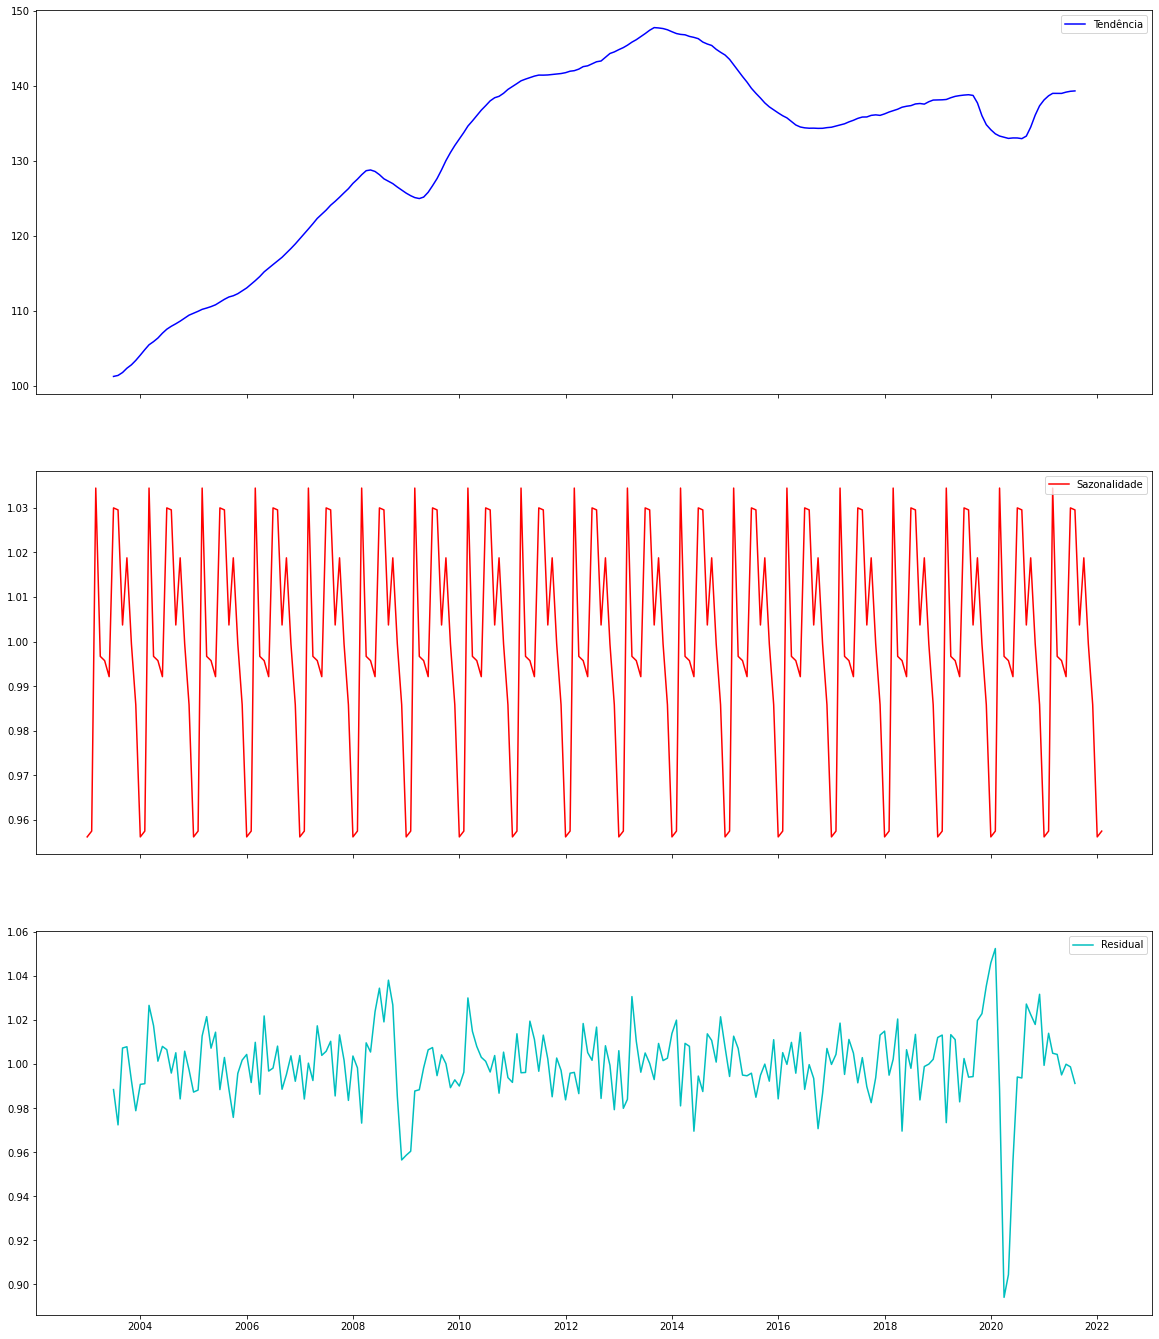

In [ ]:
fig, axis = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(24)

axis[0].plot(decomposed_series.trend, 'b', label='Tendência')
axis[0].legend()

axis[1].plot(decomposed_series.seasonal, 'r', label='Sazonalidade')
axis[1].legend()

axis[2].plot(decomposed_series.resid, 'c', label='Residual')
axis[2].legend()

fig.show()

In [ ]:
df_moving_average = df.rolling(window=12).sum() / 12

In [ ]:
df_moving_average = df_moving_average[13:]

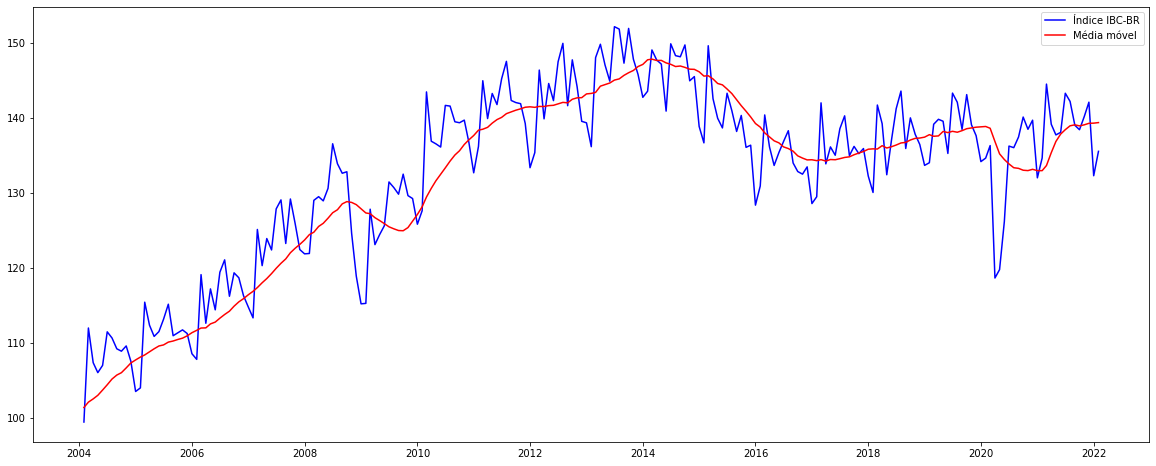

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df['valor'][13:], 'b', label='Índice IBC-BR')
plt.plot(df_moving_average, 'r', label='Média móvel')
plt.legend()
plt.show()

In [ ]:
for window in df.rolling(window=12, min_periods=12):
  print(window)

            valor
data             
2003-01-01  96.15
            valor
data             
2003-01-01  96.15
2003-02-01  98.67
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19
2003-05-01  100.30
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19
2003-05-01  100.30
2003-06-01   98.58
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19
2003-05-01  100.30
2003-06-01   98.58
2003-07-01  103.05
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19
2003-05-01  100.30
2003-06-01   98.58
2003-07-01  103.05
2003-08-01  101.47
             valor
